In [130]:
# Modul Dasar
import numpy as np               # Operasi matematika dan array
import pandas as pd              # Struktur data tabular (DataFrame)
import matplotlib.pyplot as plt  # Visualisasi data
import seaborn as sns            # Visualisasi data tambahan

# Statistik dan Machine Learning
from scipy import stats          # Statistik
from sklearn import datasets     # Datasets untuk machine learning
from sklearn.model_selection import train_test_split  # Pembagian data train-test
from sklearn.preprocessing import StandardScaler     # Normalisasi data
from sklearn.linear_model import LinearRegression    # Regresi linear
from sklearn.tree import DecisionTreeClassifier      # Klasifikasi menggunakan Decision Tree
from sklearn.cluster import KMeans                    # KMeans clustering

# Evaluasi Model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report  # Evaluasi performa model

# Visualisasi Machine Learning
from sklearn.tree import plot_tree    # Visualisasi struktur Decision Tree
from sklearn.metrics import roc_curve, auc  # Kurva ROC dan AUC


from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

In [131]:
import numpy as np
import tensorflow as tf

# Set seed for numpy
np.random.seed(42)

# Set seed for TensorFlow
tf.random.set_seed(42)


In [132]:
data = pd.read_csv("../data/external/ihsg 14-12-22 till 22-04-24.csv")
# data = pd.read_csv("../data/external/5 tahun.csv")
sentiment = pd.read_csv("../data/processed/preprocces-data.csv")

data.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-12-14,6810.355957,6854.098145,6774.131836,6801.749023,6801.749023,215430000
1,2022-12-15,6801.789063,6801.837891,6740.955078,6751.859863,6751.859863,145093400
2,2022-12-16,6751.859863,6812.192871,6693.765137,6812.192871,6812.192871,156126900


In [133]:
sentiment


sentiment_mapping = {"positive": 0, "negative": 1, "neutral": 2}

data['Sentiment'] = sentiment['sentiment'].map(sentiment_mapping)

In [134]:
data.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume,Sentiment
0,2022-12-14,6810.355957,6854.098145,6774.131836,6801.749023,6801.749023,215430000,2
1,2022-12-15,6801.789063,6801.837891,6740.955078,6751.859863,6751.859863,145093400,1
2,2022-12-16,6751.859863,6812.192871,6693.765137,6812.192871,6812.192871,156126900,1


In [135]:
lengh_data = len(data)
split_ratio = 0.8
lengh_train = round(lengh_data * split_ratio)
lengh_validation = lengh_data -lengh_train

In [136]:
data = data.drop(["Volume"],axis=1)
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index("Date")

#hai widha

In [137]:
def time_series_to_supervised(data, n_in=1, n_out=1, dropnan=True, var_names=None):
    """
    Mengubah data time series menjadi data supervised learning.

    Argumen:
    data: DataFrame, dataset time series yang akan diubah.
    n_in: int, jumlah timestep mundur sebagai input (X).
    n_out: int, jumlah timestep maju sebagai output (y).
    dropnan: bool, apakah akan menghapus baris dengan nilai NaN.
    var_names: list of str, nama variabel untuk setiap kolom.

    Returns:
    DataFrame yang sudah diubah menjadi format supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = [], []
    
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        if var_names is None:
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        else:
            names += [(var_names[j] + '(t-%d)' % i) for j in range(n_vars)]
    
    # Output sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            if var_names is None:
                names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
            else:
                names += [(var_names[j] + '(t)') for j in range(n_vars)]
        else:
            if var_names is None:
                names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            else:
                names += [(var_names[j] + '(t+%d)' % i) for j in range(n_vars)]
    
    # Concatenate semua kolom
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # Hapus baris dengan nilai NaN
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg

# Contoh penggunaan:
# Misalkan 'data' adalah DataFrame yang berisi data time series
# dengan tiga fitur, dan kita ingin menggunakan 3 timestep mundur sebagai input
# dan 1 timestep maju sebagai output, dan nama variabel untuk setiap fitur adalah
# 'A', 'B', dan 'C'

var_names = data.columns
data_supervised = time_series_to_supervised(data, n_in=15, n_out=1, var_names=var_names)


In [138]:
train_data = data_supervised[:lengh_train]
validation_data = data_supervised[lengh_train:]

In [139]:
from sklearn.preprocessing import MinMaxScaler

# Inisialisasi MinMaxScaler
scaler = MinMaxScaler()

# Normalisasi data train
scaled_train_data = scaler.fit_transform(train_data)

# Konversi data yang telah dinormalisasi kembali ke dalam DataFrame
scaled_train_data = pd.DataFrame(scaled_train_data, columns=train_data.columns)



In [140]:
y_train_scaled = scaled_train_data[["Open(t)"]]  # Ambil kolom Open(t) sebagai target
X_train_scaled = scaled_train_data.drop(["Open(t)", "Close(t)", "High(t)", "Low(t)", "Adj Close(t)","Sentiment(t)"], axis=1)

In [141]:
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255 entries, 0 to 254
Data columns (total 90 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open(t-15)       255 non-null    float64
 1   High(t-15)       255 non-null    float64
 2   Low(t-15)        255 non-null    float64
 3   Close(t-15)      255 non-null    float64
 4   Adj Close(t-15)  255 non-null    float64
 5   Sentiment(t-15)  255 non-null    float64
 6   Open(t-14)       255 non-null    float64
 7   High(t-14)       255 non-null    float64
 8   Low(t-14)        255 non-null    float64
 9   Close(t-14)      255 non-null    float64
 10  Adj Close(t-14)  255 non-null    float64
 11  Sentiment(t-14)  255 non-null    float64
 12  Open(t-13)       255 non-null    float64
 13  High(t-13)       255 non-null    float64
 14  Low(t-13)        255 non-null    float64
 15  Close(t-13)      255 non-null    float64
 16  Adj Close(t-13)  255 non-null    float64
 17  Sentiment(t-13) 

In [142]:
y_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255 entries, 0 to 254
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Open(t)  255 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


In [143]:
# Misalnya, Anda memiliki 3 langkah waktu dan 5 fitur
timesteps = 15
features = 6
X_train = []
for i in range(timesteps):
    X_train.append(X_train_scaled.iloc[:, i*features:(i+1)*features].values)

# Ubah list menjadi array numpy
X_train = np.array(X_train)
X_train = X_train.transpose(1, 0, 2)
# Bentuknya menjadi (jumlah_sampel, timestep, feature)
print(X_train.shape)

(255, 15, 6)


In [144]:
from keras.layers import LSTM
from keras.layers import Bidirectional

model_lstm = Sequential()
model_lstm.add(Bidirectional(LSTM(128, activation='relu',return_sequences=True, input_shape=(X_train.shape[1], 5))))
model_lstm.add(Dropout(0.1))
model_lstm.add(LSTM(128,activation='relu', return_sequences=False))
model_lstm.add(Dense(128))
model_lstm.add(Dense(1))


In [145]:
early_stopping = EarlyStopping(monitor='loss', patience=20, verbose=1, restore_best_weights=True)

model_lstm.compile(optimizer='adam', loss='mse')



In [146]:
# Fit the model with early stopping
hist = model_lstm.fit(X_train, train_data['Open(t)'], 
                      epochs=200, 
                      batch_size=32,
                      callbacks=[early_stopping])

Epoch 1/200


8/8 [==============================] - 7s 52ms/step - loss: 47418816.0000
Epoch 2/200
8/8 [==============================] - 0s 54ms/step - loss: 45257988.0000
Epoch 3/200
8/8 [==============================] - 0s 54ms/step - loss: 26296076.0000
Epoch 4/200
8/8 [==============================] - 0s 56ms/step - loss: 23603428.0000
Epoch 5/200
8/8 [==============================] - 0s 56ms/step - loss: 6031347.5000
Epoch 6/200
8/8 [==============================] - 0s 55ms/step - loss: 1486928.1250
Epoch 7/200
8/8 [==============================] - 1s 57ms/step - loss: 1126872.5000
Epoch 8/200
8/8 [==============================] - 0s 52ms/step - loss: 897495.5625
Epoch 9/200
8/8 [==============================] - 0s 55ms/step - loss: 711487.1250
Epoch 10/200
8/8 [==============================] - 0s 56ms/step - loss: 605960.8125
Epoch 11/200
8/8 [==============================] - 0s 52ms/step - loss: 535121.1875
Epoch 12/200
8/8 [==============================] - 0s 52ms/step - loss: 48

In [147]:
y_pred = model_lstm.predict(X_train)

8/8 [==============================] - 1s 14ms/step


In [148]:
y_pred.shape

(255, 1)

In [149]:
y_pred.squeeze()

array([6866.4175, 6812.6772, 6788.551 , 6766.618 , 6742.671 , 6701.731 ,
       6664.3394, 6624.6523, 6608.261 , 6704.7534, 6749.5137, 6768.002 ,
       6789.852 , 6833.5254, 6893.199 , 6860.817 , 6870.436 , 6960.6665,
       6903.138 , 6916.346 , 6974.6514, 6914.929 , 6934.8223, 6983.2837,
       6917.595 , 6926.812 , 6947.6753, 6979.6147, 6915.8315, 6915.098 ,
       6904.4907, 6904.536 , 6858.6885, 6848.901 , 6847.275 , 6856.3022,
       6869.941 , 6870.2437, 6886.32  , 6902.1333, 6903.548 , 6886.0625,
       6877.139 , 6889.5137, 6916.5854, 6902.3604, 6884.07  , 6871.6606,
       6853.097 , 6802.1772, 6727.746 , 6680.571 , 6645.601 , 6631.038 ,
       6708.7183, 6726.091 , 6697.723 , 6817.854 , 6832.521 , 6869.642 ,
       6844.4976, 6901.901 , 6868.9917, 6846.915 , 6847.2466, 6836.527 ,
       6833.228 , 6819.9487, 6874.891 , 6822.1494, 6751.929 , 6829.138 ,
       6812.969 , 6866.7446, 6830.932 , 6851.3486, 6872.639 , 6874.2886,
       6861.4985, 6846.279 , 6849.086 , 6874.625 , 

In [150]:
train_data['Open(t)']

Date
2023-01-04    6888.798828
2023-01-05    6813.279785
2023-01-06    6653.759766
2023-01-09    6684.558105
2023-01-10    6688.265137
                 ...     
2024-01-19    7271.341797
2024-01-22    7233.172852
2024-01-23    7232.516113
2024-01-24    7255.770020
2024-01-25    7215.526855
Name: Open(t), Length: 255, dtype: float64

In [151]:
mse = np.mean((y_pred.squeeze() - train_data['Open(t)'])**2)

# Menghitung Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print("MSE:", mse)
print("RMSE:", rmse)

MSE: 4440.013478973484
RMSE: 66.63342613863918


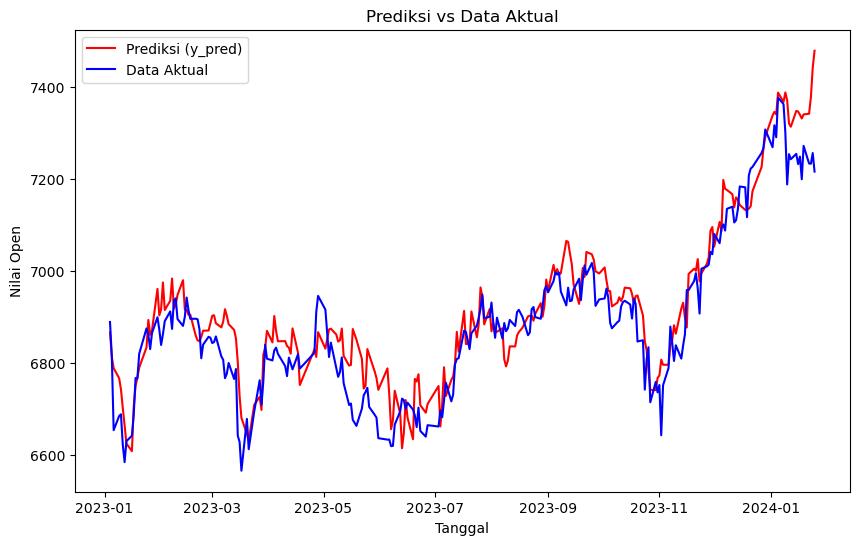

In [152]:
import matplotlib.pyplot as plt

# Plot hasil prediksi (y_pred) dan data aktual (train_data['Open(t)'])
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, y_pred.squeeze(), label='Prediksi (y_pred)', color='red')
plt.plot(train_data.index, train_data['Open(t)'], label='Data Aktual', color='blue')
plt.xlabel('Tanggal')
plt.ylabel('Nilai Open')
plt.title('Prediksi vs Data Aktual')
plt.legend()
plt.show()


In [153]:
scaled_val_data = scaler.fit_transform(validation_data)

# Konversi data yang telah dinormalisasi kembali ke dalam DataFrame
scaled_val_data = pd.DataFrame(scaled_val_data, columns=validation_data.columns)

In [154]:
scaled_val_data

,Open(t-15),High(t-15),Low(t-15),Close(t-15),Adj Close(t-15),Sentiment(t-15),Open(t-14),High(t-14),Low(t-14),Close(t-14),...,Low(t-1),Close(t-1),Adj Close(t-1),Sentiment(t-1),Open(t),High(t),Low(t),Close(t),Adj Close(t),Sentiment(t)
0,0.832718,0.823219,0.858695,0.720836,0.720836,1.0,0.780944,0.786917,0.601128,0.494510,...,0.336588,0.156050,0.156050,0.0,0.074196,0.080254,0.176720,0.143848,0.143848,0.0
1,0.780944,0.786917,0.601128,0.494510,0.494510,0.0,0.554585,0.503715,0.276769,0.213064,...,0.099898,0.020653,0.020653,0.0,0.058582,0.115435,0.221554,0.201903,0.201903,1.0
2,0.554585,0.503715,0.276769,0.213064,0.213064,1.0,0.146671,0.322879,0.183643,0.304526,...,0.148916,0.087062,0.087062,1.0,0.056940,0.228876,0.273767,0.303178,0.303178,1.0
3,0.146671,0.322879,0.183643,0.304526,0.304526,0.5,0.386163,0.385084,0.412662,0.279772,...,0.206001,0.202910,0.202910,1.0,0.283465,0.338601,0.439673,0.348626,0.348626,0.5
4,0.386163,0.385084,0.412662,0.279772,0.279772,1.0,0.345849,0.365522,0.364168,0.351252,...,0.387388,0.254898,0.254898,0.5,0.312761,0.341834,0.437005,0.330577,0.330577,1.0
5,0.345849,0.365522,0.364168,0.351252,0.351252,1.0,0.388304,0.398151,0.366040,0.293400,...,0.384471,0.234251,0.234251,1.0,0.312928,0.310688,0.405140,0.437772,0.437772,1.0
6,0.388304,0.398151,0.366040,0.293400,0.293400,0.0,0.306848,0.352686,0.378745,0.356818,...,0.349632,0.356871,0.356871,1.0,0.365844,0.359602,0.421480,0.321673,0.321673,0.0
7,0.306848,0.352686,0.378745,0.356818,0.356818,1.0,0.366379,0.298053,0.216439,0.214521,...,0.367498,0.224067,0.224067,0.0,0.341206,0.404487,0.494467,0.462694,0.462694,1.0
8,0.366379,0.298053,0.216439,0.214521,0.214521,0.5,0.187643,0.348870,0.294595,0.391183,...,0.447295,0.385380,0.385380,1.0,0.460611,0.458811,0.531873,0.427271,0.427271,1.0
9,0.187643,0.348870,0.294595,0.391183,0.391183,1.0,0.451186,0.386745,0.244843,0.304881,...,0.488191,0.344859,0.344859,1.0,0.472127,0.526029,0.601745,0.607957,0.607957,1.0


In [155]:
y_val_scaled = scaled_val_data[["Open(t)"]]  # Ambil kolom Open(t) sebagai target
X_val_scaled = scaled_val_data.drop(["Open(t)", "Close(t)", "High(t)", "Low(t)", "Adj Close(t)","Sentiment(t)"], axis=1)

In [156]:

X_val = []
for i in range(timesteps):
    X_val.append(X_val_scaled.iloc[:, i*features:(i+1)*features].values)

# Ubah list menjadi array numpy
X_val = np.array(X_val)
X_val = X_val.transpose(1, 0, 2)
# Bentuknya menjadi (jumlah_sampel, timestep, feature)
print(X_val.shape)

(49, 15, 6)


In [157]:
y_val_pred = model_lstm.predict(X_val)

2/2 [==============================] - 0s 12ms/step


In [158]:
y_val_pred.squeeze()

array([7030.86  , 6908.1387, 6835.1216, 6759.2983, 6752.0503, 6746.78  ,
       6735.315 , 6788.529 , 6772.868 , 6912.279 , 6951.8267, 7002.3794,
       7037.2446, 7048.354 , 7023.3857, 7078.322 , 7201.897 , 7179.3315,
       7091.8774, 7125.0093, 7096.0776, 7029.0967, 7116.3867, 7098.0674,
       7119.0615, 7077.243 , 7140.988 , 7199.244 , 7192.253 , 7265.951 ,
       7343.362 , 7316.685 , 7247.2007, 7223.9683, 7229.9604, 7254.408 ,
       7205.8496, 7149.191 , 7090.405 , 7059.6626, 7175.932 , 7242.245 ,
       7246.637 , 7239.3223, 7145.5757, 7013.479 , 6968.1177, 6990.7334,
       6973.224 ], dtype=float32)

In [159]:
validation_data['Open(t)']

Date
2024-01-26    7152.269043
2024-01-29    7147.714844
2024-01-30    7147.235840
2024-01-31    7213.307129
2024-02-01    7221.852051
2024-02-02    7221.900879
2024-02-05    7237.334961
2024-02-06    7230.148926
2024-02-07    7264.976074
2024-02-12    7268.334961
2024-02-13    7301.587891
2024-02-15    7337.630859
2024-02-16    7337.815918
2024-02-19    7323.312012
2024-02-20    7320.723145
2024-02-21    7345.791016
2024-02-22    7334.952148
2024-02-23    7326.526855
2024-02-26    7277.640137
2024-02-27    7263.987793
2024-02-28    7292.075195
2024-02-29    7326.803223
2024-03-01    7318.666016
2024-03-04    7318.832031
2024-03-05    7296.534180
2024-03-06    7252.084961
2024-03-07    7338.731934
2024-03-08    7398.429199
2024-03-13    7422.301758
2024-03-14    7405.566895
2024-03-15    7408.658203
2024-03-18    7338.076172
2024-03-19    7320.538086
2024-03-20    7303.929199
2024-03-21    7360.558105
2024-03-22    7327.514160
2024-03-25    7339.523926
2024-03-26    7337.661133
2024-03

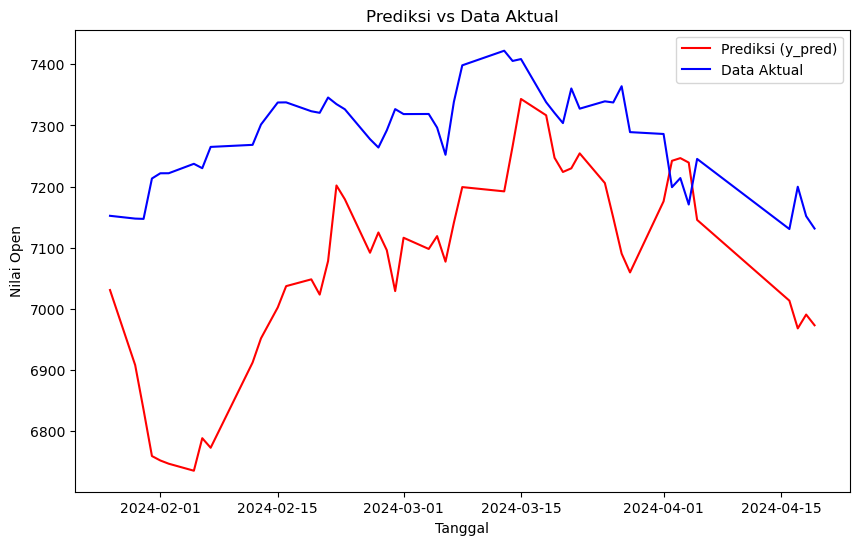

In [160]:
import matplotlib.pyplot as plt

# Plot hasil prediksi (y_pred) dan data aktual (train_data['Open(t)'])
plt.figure(figsize=(10, 6))
plt.plot(validation_data.index, y_val_pred.squeeze(), label='Prediksi (y_pred)', color='red')
plt.plot(validation_data.index, validation_data['Open(t)'], label='Data Aktual', color='blue')
plt.xlabel('Tanggal')
plt.ylabel('Nilai Open')
plt.title('Prediksi vs Data Aktual')
plt.legend()
plt.show()


In [161]:
mse = np.mean((y_val_pred.squeeze() - validation_data['Open(t)'])**2)

# Menghitung Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print("MSE:", mse)
print("RMSE:", rmse)

MSE: 63059.68276439548
RMSE: 251.11687072834332
